In [ ]:
%pip install cartopy
%pip install xarray
%pip install netcdf4

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import seaborn as sns
import pickle
from src.score import *
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm_notebook as tqdm

The following functions are to setup reading & writing save files for the models created

In [4]:
def to_pickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)
def read_pickle(fn):
    with open(fn, 'rb') as f:
        return pickle.load(f)

In [9]:
# Read in Dataset
z500 = xr.open_mfdataset('geopotential_500/*.nc', combine= 'by_coords').z
z500_test = load_test_data('geopotential_500/', 'z')

In [ ]:
# Split into train and test data
data_train = z500.sel(time=slice('1979', '2016'))

data_test = z500.sel(time=slice('2017', '2018'))

In [ ]:
# Compute normalization statistics
data_mean = data_train.isel(time=slice(0, None, 10000)).mean().load()
data_std = data_train.isel(time=slice(0, None, 10000)).std().load()

In [8]:
data_train = (data_train - data_mean) / data_std
data_test = (data_test - data_mean) / data_std

In [9]:
_, nlat, nlon = data_train.shape; nlat, nlon

(32, 64)

In [10]:
def create_training_data(da, lead_time_h, return_valid_time=False):
    """Function to split input and output by lead time."""
    X = da.isel(time=slice(0, -lead_time_h))
    y = da.isel(time=slice(lead_time_h, None))
    valid_time = y.time
    if return_valid_time:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon), valid_time
    else:
        return X.values.reshape(-1, nlat*nlon), y.values.reshape(-1, nlat*nlon)

In [11]:
def train_lr(X_train, y_train, X_test, y_test, valid_time, lead_time_h, data_subsample= 1):

    lr = LinearRegression(n_jobs = 16)
    lr.fit(X_train, y_train)

    mse_train = mean_squared_error(y_train, lr.predict(X_train))
    mse_test = mean_squared_error(y_test, lr.predict(X_test))
    print(f'Train MSE = {mse_train}\nTest MSE = {mse_test}')

    pred = lr.predict(X_test).reshape((-1, 1, nlat, nlon))
    p = xr.DataArray(
        pred[:, 0] * data_std.values + data_mean.values,
        dims= ['time', 'lat', 'lon'],
        coords= {
            'time': valid_time,
            'lat': data_train.lat,
            'lon': data_train.lon
        },
        name= 'z'
    )
    
    return p, lr



In [12]:
def train_rr(X_train, y_train, X_test, y_test, valid_time, lead_time_h, data_subsample= 1):
    
    rr = Ridge(alpha= 10)
    rr.fit(X_train, y_train)

    mse_train = mean_squared_error(y_train, rr.predict(X_train))
    mse_test = mean_squared_error(y_test, rr.predict(X_test))
    print(f'Train MSE = {mse_train}\nTest MSE = {mse_test}')

    pred = rr.predict(X_test).reshape((-1, 1, nlat, nlon))
    p = xr.DataArray(
        pred[:, 0] * data_std.values + data_mean.values,
        dims= ['time', 'lat', 'lon'],
        coords= {
            'time': valid_time,
            'lat': data_train.lat,
            'lon': data_train.lon
        },
        name= 'z'
    )

    return p, rr

In [13]:
def train_lasso(X_train, y_train, X_test, y_test, valid_time, lead_time_h, data_subsample= 1):
    
    lasso = Lasso(alpha= 100, max_iter= 100)
    lasso.fit(X_train, y_train)

    mse_train = mean_squared_error(y_train, lasso.predict(X_train))
    mse_test = mean_squared_error(y_test, lasso.predict(X_test))

    print(f'Train MSE = {mse_train}\nTest MSE = {mse_test}')

    pred = lasso.predict(X_test).reshape((-1, 1, nlat, nlon))
    p = xr.DataArray(
        pred[:, 0] * data_std.values + data_mean.values,
        dims= ['time', 'lat', 'lon'],
        coords= {
            'time': valid_time,
            'lat': data_train.lat,
            'lon': data_train.lon
        },
        name= 'z'
    )

    return p, lasso

In [ ]:
# Initialize dataframe for table/scatterplot
df = pd.DataFrame(columns=['model', 'lead_time', 'RMSE'])
rmse_scores = []

## 3 Day Projections

In [ ]:
data_subsample = 5
lead_time = 3*24

X_train, y_train, X_test, y_test = [], [], [], []
X, y = create_training_data(data_train, lead_time)

X_train.append(X)
y_train.append(y)
X, y, valid_time = create_training_data(data_test, lead_time, return_valid_time=True)
X_test.append(X)
y_test.append(y)

X_train, y_train, X_test, y_test = [np.concatenate(d, 1) for d in [X_train, y_train, X_test, y_test]]

X_train = X_train[::data_subsample]
y_train = y_train[::data_subsample]

In [ ]:
three_day_lr, lr = train_lr(X_train, y_train, X_test, y_test, valid_time, lead_time, data_subsample= data_subsample)

In [ ]:
three_day_rr, rr = train_rr(X_train, y_train, X_test, y_test, valid_time, lead_time, data_subsample= data_subsample)

Train MSE = 0.048138540238142014
Test MSE = 0.05565313622355461


array(681.53433364)

In [ ]:
three_day_lasso, lasso = train_lasso(X_train, y_train, X_test, y_test, valid_time, lead_time, data_subsample= data_subsample)

Train MSE = 0.14833804965019226
Test MSE = 0.1405065953731537


array(1074.9609775)

##### Save/Read in the models

The following 2 cells do not need to be ran unless you plan to reuse the predictions made by these models later

In [ ]:
# Save the newly created models
three_day_lr.to_netcdf('models/lr_3d_z500.nc');
to_pickle(lr, 'models/saved_models/lr_3d_z500.pkl')

three_day_rr.to_netcdf('models/rr_3d_z500.nc');
to_pickle(rr, 'models/saved_models/rr_3d_z500.pkl')

three_day_lasso.to_netcdf('models/lasso_3d_z500.nc');
to_pickle(lasso, 'models/saved_models/lasso_3d_z500.pkl')

In [7]:
# Open models that have already been trained and saved
three_day_lr = xr.open_mfdataset('models/lr_3d_z500.nc').z
three_day_rr = xr.open_mfdataset('models/rr_3d_z500.nc').z
three_day_lasso = xr.open_mfdataset('models/lasso_3d_z500.nc').z

##### Generate RMSE Scores

In [12]:
lr_r = compute_weighted_rmse(three_day_lr, z500_test).compute().values.item()
rr_r = compute_weighted_rmse(three_day_rr, z500_test).compute().values.item()
lasso_r = compute_weighted_rmse(three_day_lasso, z500_test).compute().values.item()

print(f'RMSE Scores for 3-day lead time:\nLinear Regression RMSE: {lr_r}\nRidge Regression RMSE: {rr_r}\nLasso Regression RMSE: {lasso_r}')

rmse_scores.extend([lr_r, rr_r, lasso_r])

RMSE Scores for 3-day lead time:
Linear Regression RMSE: 693.2846463180001
Ridge Regression RMSE: 675.6774798490626
Lasso Regression RMSE: 1074.5517588598063


# 5-day Predictions

In [19]:
data_subsample = 5
lead_time = 5*24

X_train, y_train, X_test, y_test = [], [], [], []
X, y = create_training_data(data_train, lead_time)

X_train.append(X)
y_train.append(y)
X, y, valid_time = create_training_data(data_test, lead_time, return_valid_time=True)
X_test.append(X)
y_test.append(y)

X_train, y_train, X_test, y_test = [np.concatenate(d, 1) for d in [X_train, y_train, X_test, y_test]]

X_train = X_train[::data_subsample]
y_train = y_train[::data_subsample]

In [ ]:
five_day_lr, lr = train_lr(X_train, y_train, X_test, y_test, valid_time, lead_time, data_subsample= data_subsample)

Train MSE = 0.05976729094982147
Test MSE = 0.07372964918613434


In [ ]:
five_day_rr, rr = train_rr(X_train, y_train, X_test, y_test, valid_time, lead_time, data_subsample= data_subsample)
r = compute_weighted_rmse(p, z500_test).compute()
r.values

Train MSE = 0.06077689677476883
Test MSE = 0.07097847759723663


array(769.14588463)

In [ ]:
five_day_rr.to_netcdf(f'models/rr_5d_z500.nc');
to_pickle(rr, f'models/saved_models/rr_5d_z500.pkl')

In [ ]:
five_day_lasso, lasso = train_lasso(X_train, y_train, X_test, y_test, valid_time, lead_time, data_subsample= data_subsample)
r = compute_weighted_rmse(p, z500_test).compute()
r.values

Train MSE = 0.14832854270935059
Test MSE = 0.1403093785047531


array(1074.55175886)

##### Save/Read in the models

The following 2 cells do not need to be ran unless you plan to reuse the predictions made by these models later

In [ ]:
# Save Newly Created Models
five_day_lr.to_netcdf('models/lr_5d_z500.nc');
to_pickle(lr, 'models/saved_models/lr_5d_z500.pkl')

five_day_rr.to_netcdf(f'models/rr_5d_z500.nc');
to_pickle(rr, f'models/saved_models/rr_5d_z500.pkl')

five_day_lasso.to_netcdf('models/lasso_5d_z500.nc');
to_pickle(lasso, 'models/saved_models/lasso_5d_z500.pkl')

In [13]:
# Read in existing models
five_day_lr = xr.open_mfdataset('models/lr_5d_z500.nc').z
five_day_rr = xr.open_mfdataset('models/rr_5d_z500.nc').z
five_day_lasso = xr.open_mfdataset('models/lasso_5d_z500.nc').z

##### Generate RMSE Scores

In [14]:
lr_r = compute_weighted_rmse(five_day_lr, z500_test).compute().values.item()
rr_r = compute_weighted_rmse(five_day_rr, z500_test).compute().values.item()
lasso_r = compute_weighted_rmse(five_day_lasso, z500_test).compute().values.item()

print(f'RMSE Scores for 5-day lead time:\nLinear Regression RMSE: {lr_r}\nRidge Regression RMSE: {rr_r}\nLasso Regression RMSE: {lasso_r}')

rmse_scores.extend([lr_r, rr_r, lasso_r])

RMSE Scores for 5-day lead time:
Linear Regression RMSE: 783.3498976626933
Ridge Regression RMSE: 769.1458846288668
Lasso Regression RMSE: 1074.5517588598063


# Create images and plots

In [28]:
df['RMSE'] = rmse_scores
df['model'] = ['LR', 'RR', 'Lasso', 'LR', 'RR', 'Lasso']
df['lead_time'] = [3, 3, 3, 5, 5, 5]
df

,model,lead_time,RMSE
0,LR,3,693.284646
1,RR,3,675.677480
2,Lasso,3,1074.551759
3,LR,5,783.349898
4,RR,5,769.145885
5,Lasso,5,1074.551759


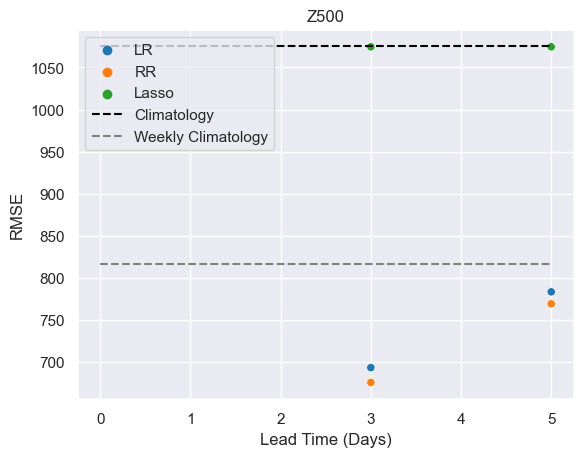

In [ ]:
## Plot RMSE Scores
sns.scatterplot(df, x= 'lead_time', y= 'RMSE', hue= 'model')
plt.hlines(y= 1075, xmin= 0, xmax= 5, color= 'black', linestyles= 'dashed', label= 'Climatology')
plt.hlines(y= 816, xmin= 0, xmax= 5, color= 'grey', linestyles= 'dashed', label= 'Weekly Climatology')
plt.xticks([0, 1, 2, 3, 4, 5])
plt.xlabel('Lead Time (Days)')
plt.ylabel('RMSE')
plt.title('Z500')
plt.legend()

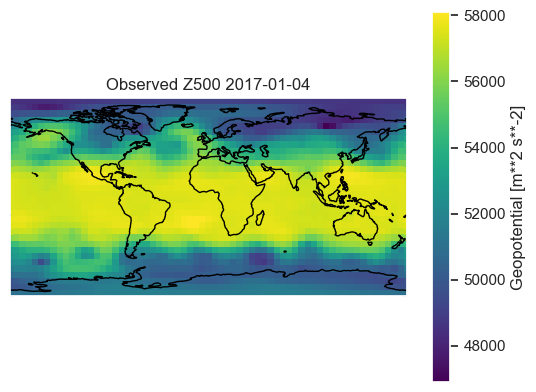

In [49]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
actual_day = z500.sel(time= slice('2017', '2017'))
actual_day.isel(time= 3*24).plot()

plt.title('Observed Z500 2017-01-04')
plt.show()

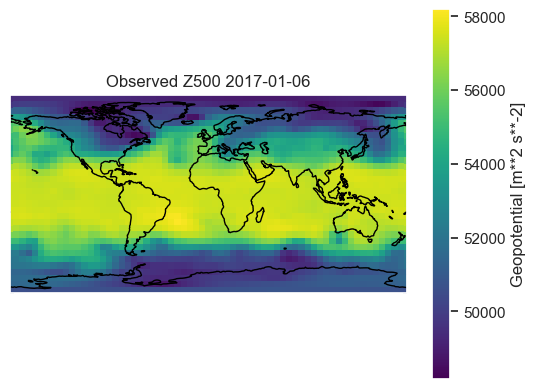

In [50]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()
actual_day = z500.sel(time= slice('2017', '2017'))
actual_day.isel(time= 5*24).plot()

plt.title('Observed Z500 2017-01-06')
plt.show()

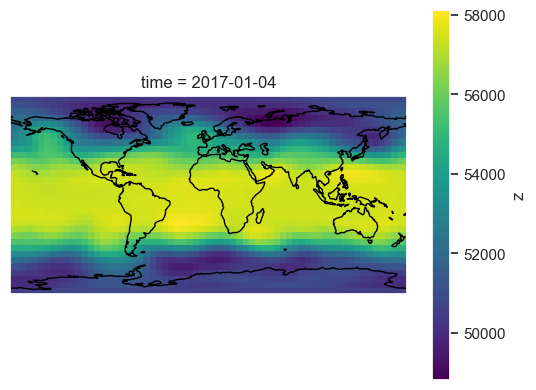

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()

three_day_lr.isel(time= 0).plot()

plt.title('Z500 Forecast (3-day LR)')
plt.show()

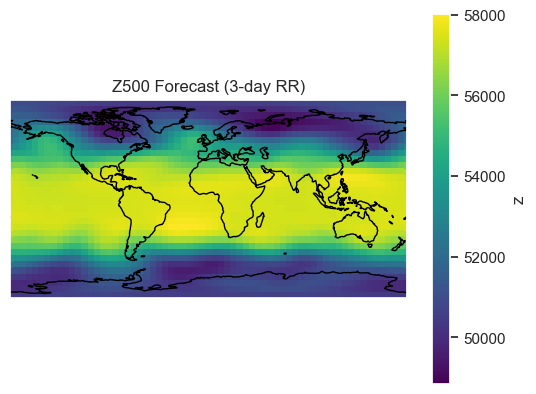

In [37]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()

three_day_rr.isel(time= 0).plot()

plt.title('Z500 Forecast (3-day RR)')
plt.show()

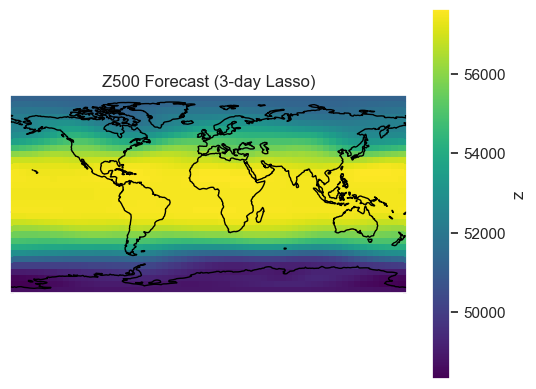

In [38]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()

three_day_lasso.isel(time= 0).plot()

plt.title('Z500 Forecast (3-day Lasso)')
plt.show()

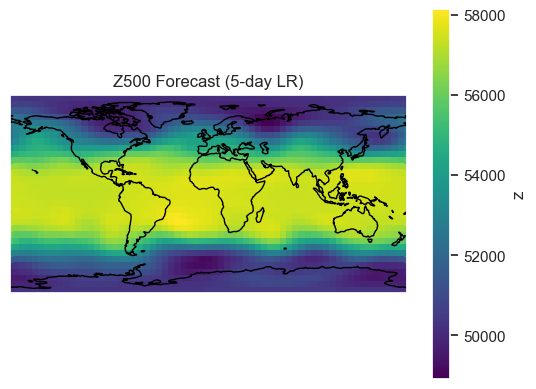

In [39]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()

five_day_lr.isel(time= 0).plot()

plt.title('Z500 Forecast (5-day LR)')
plt.show()

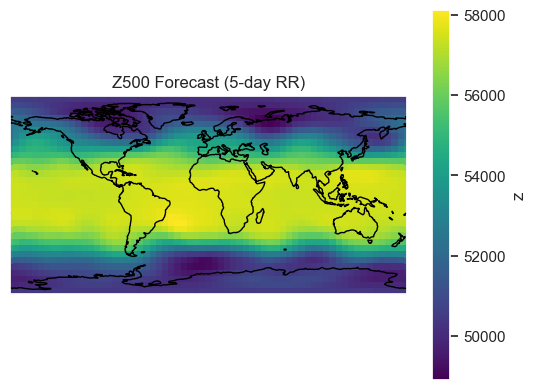

In [40]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()

five_day_rr.isel(time= 0).plot()

plt.title('Z500 Forecast (5-day RR)')
plt.show()

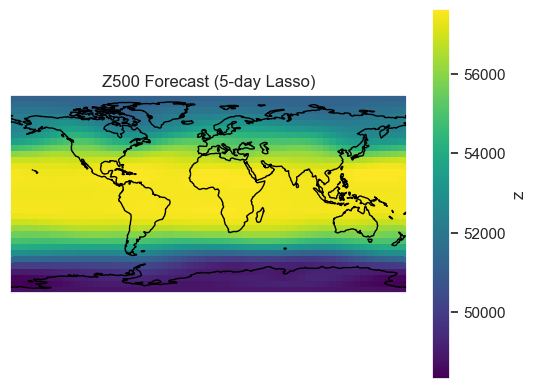

In [41]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.coastlines()

five_day_lasso.isel(time= 0).plot()

plt.title('Z500 Forecast (5-day Lasso)')
plt.show()